In [1]:
import copy
import numpy as np
import sys
import py2tex.py2tex as py2tex
import verdict
import os

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as path_effects
import matplotlib.cm as cm
import matplotlib.colors as plt_colors

In [3]:
import linefinder.analyze_data.worldlines as a_worldlines
import linefinder.analyze_data.plot_worldlines as p_worldlines
import linefinder.utils.presentation_constants as p_constants

In [4]:
import galaxy_dive.analyze_data.ahf as analyze_ahf
import galaxy_dive.plot_data.ahf as plot_ahf
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.plot_data.generic_plotter as generic_plotter
import galaxy_dive.plot_data.plotting as plotting
import galaxy_dive.utils.data_operations as data_operations
import galaxy_dive.utils.executable_helpers as exec_helpers

In [5]:
import linefinder.utils.file_management as file_management
import linefinder.config as config

# Load Data

In [6]:
sim_name = 'm12i'
snum = 600

In [7]:
galdef = ''

In [8]:
file_manager = file_management.FileManager( 'hot_halo_physics' )

In [9]:
defaults = file_manager.get_linefinder_analysis_defaults(
    '_hothaloacc',
    sim_name = sim_name,
    galdef = galdef
)

In [282]:
ind = defaults['ahf_index'] - snum

In [11]:
w = a_worldlines.Worldlines( **defaults )

In [12]:
w.retrieve_halo_data()

Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


In [13]:
print( w.tag )

m12i_hothaloacc


In [14]:
m_plot_label  = r'$M_{\rm h} = 10^{' + '{:.02g}'.format( np.log10( w.m_vir[snum] ) )
m_plot_label += '} M_\odot$'
plot_label = m_plot_label + ', z={:.02}'.format( w.redshift[snum] )
print( plot_label )

$M_{\rm h} = 10^{12} M_\odot$, z=0.0


In [15]:
classification_list = copy.copy( p_constants.CLASSIFICATIONS_CGM_FATE )

In [16]:
w_plotter = p_worldlines.WorldlinesPlotter( w, label=plot_label )

# Calculate $\theta$
Also called $\phi$...

In [17]:
s_data = particle_data.ParticleData(
    sdir = file_manager.get_sim_dir( sim_name ),
    snum = snum,
    ptype = config.PTYPE_STAR,
    halo_data_dir = file_manager.get_halo_dir( sim_name ),
    main_halo_id = config.MAIN_MT_HALO_ID[sim_name],    
)

In [18]:
w.calc_abs_phi( normal_vector=s_data.total_ang_momentum )

# Hot Mode Accretion Investigation

In [19]:
# Setup axes
t_window = 1.
t = w.get_data( 'time' )
x_range = [ t[ind] - t_window, t[ind] ]

In [20]:
t_snaps = t[( t > x_range[0] ) & ( t < x_range[1] )][::-1]

In [21]:
n_snaps = t_snaps.size

In [22]:
dt = t_snaps[1:] - t_snaps[:-1]

In [23]:
t_bins = np.zeros( ( t_snaps.size + 1, ) )
t_bins[1:-1] = t_snaps[:-1] + dt / 2.
t_bins[0] = t_snaps[0] - dt[0] / 2.
t_bins[-1] = t_snaps[-1] + dt[-1] / 2.

## Distribution Plots

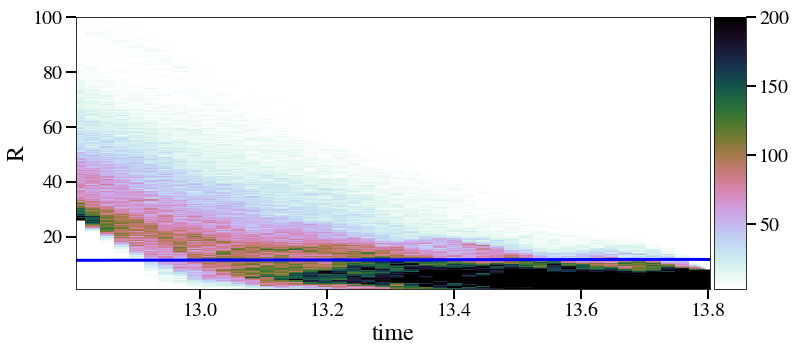

In [24]:
%matplotlib inline

fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'R',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=200 ),
    cmap = cm.cubehelix_r,
#     y_scale = 'log',
    y_range = [ 1., 100. ],
    x_range = x_range,
    n_bins_y = 512,
#     conditional_y = True,
    x_edges = t_bins,
)

ax.plot(
    w.get_data( 'time' )[:w.r_gal.size],
    w.r_gal,
    color = 'blue',
    linewidth = 3,
)

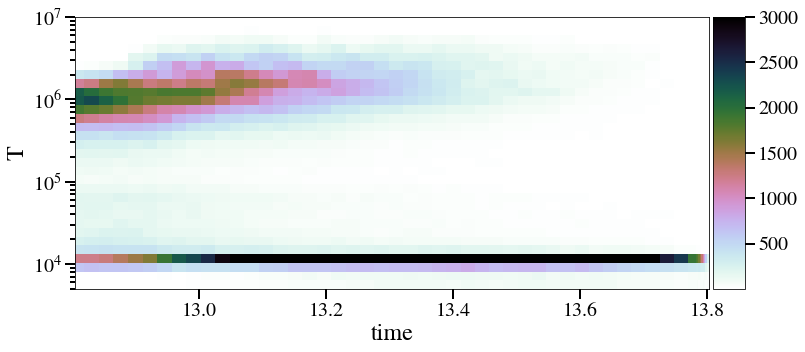

In [25]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'T',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=3000 ),
    y_scale = 'log',
    cmap = cm.cubehelix_r,
    y_range = [ 5e3, 1e7 ],
    x_range = x_range,
    x_edges = t_bins,
    n_bins_y = 32,
)

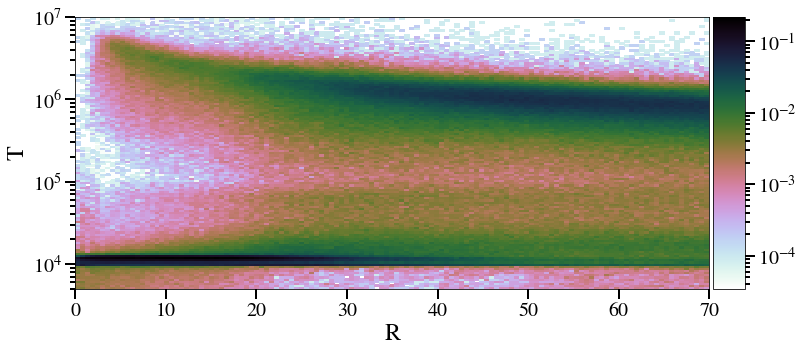

In [26]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'T',
    ax = ax,
    x_data_args = { 'tile_data': True },
#     z_scale = plt_colors.Normalize( vmin=3, vmax=1000 ),
    y_scale = 'log',
    cmap = cm.cubehelix_r,
    x_range = [ 0, 70 ],
    y_range = [ 5e3, 1e7 ],
#     x_range = x_range,
    n_bins_x = 128,
    n_bins = 128,
    conditional_y = True,
)

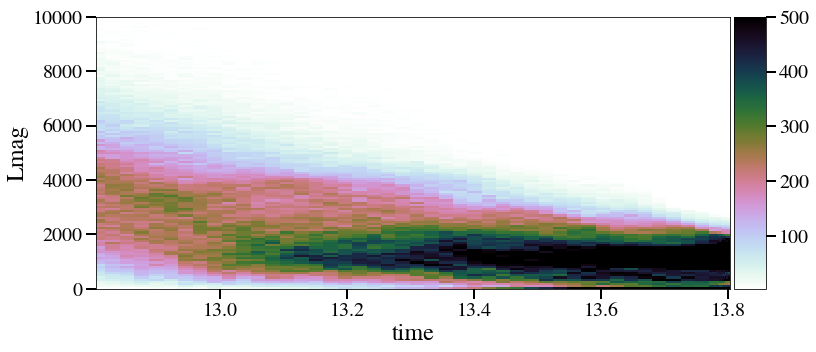

In [27]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

y_data = w.get_selected_data( 'Lmag' ) / w.get_selected_data( 'M' )

w_plotter.histogram2d(
    'time',
    'Lmag',
    y_data = y_data,
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
#     y_scale = 'log',
    y_range = [ 0, 10000 ],
    x_range = x_range,
    x_edges = t_bins,
    cmap = cm.cubehelix_r,
)

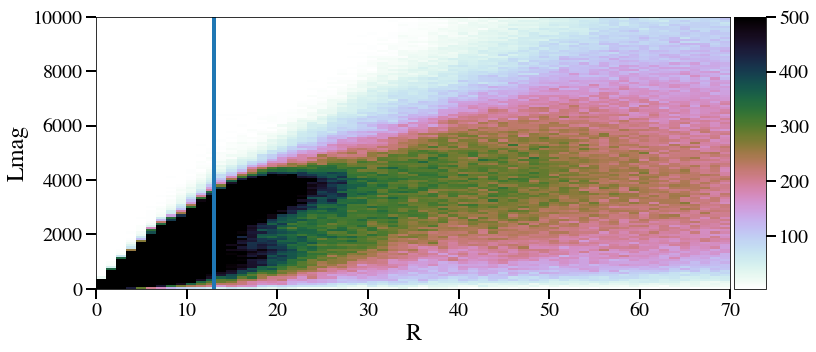

In [28]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

y_data = w.get_selected_data( 'Lmag' ) / w.get_selected_data( 'M' )

w_plotter.histogram2d(
    'R',
    'Lmag',
    y_data = y_data,
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=500 ),
#     y_scale = 'log',
    y_range = [ 0, 10000 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

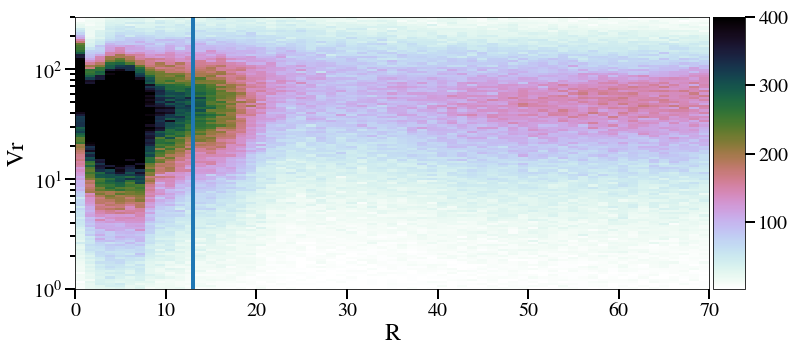

In [29]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'Vr',
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
    y_scale = 'log',
    y_range = [ 1., 300 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
    cmap = cm.cubehelix_r,
)

ax.axvline(
    13,
    linewidth = 4,
)

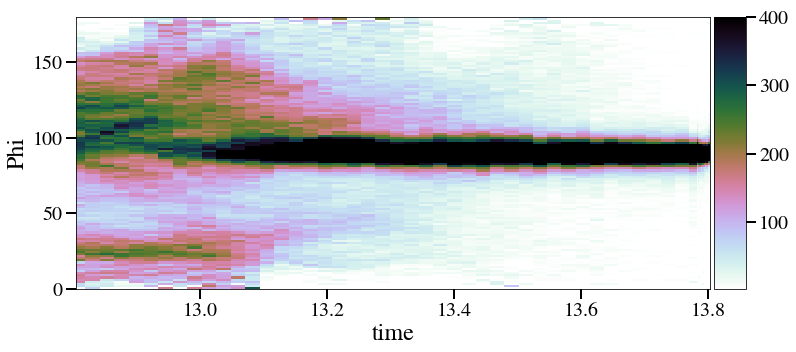

In [30]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'time',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=400 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = x_range,
    x_edges = t_bins,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

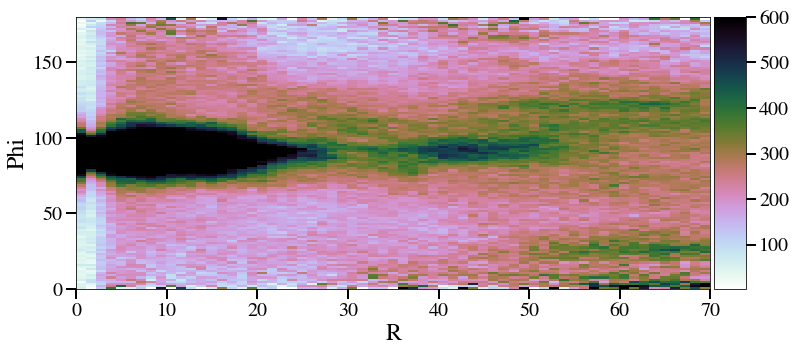

In [31]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'R',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=600 ),
#     y_scale = 'log',
#     y_range = [ 1e3, 1e7 ],
    x_range = [ 0, 70 ],
    n_bins_x = 64,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

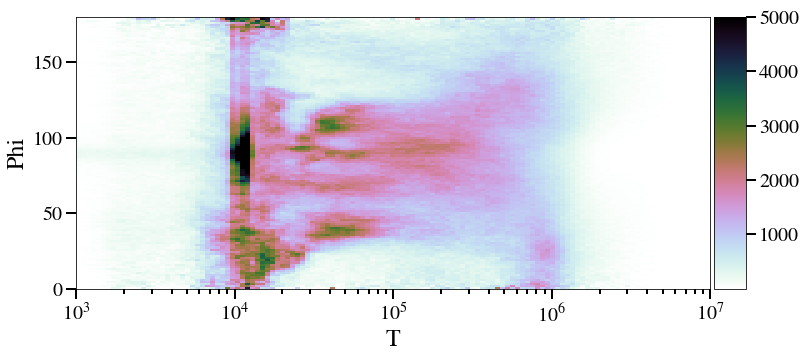

In [32]:
fig = plt.figure( figsize=(12, 5), facecolor='white' )
ax = plt.gca()

w_plotter.histogram2d(
    'T',
    'Phi',
    weight_key = '1/sin',
    weight_data = 1. / np.sin( w.get_selected_data( 'Phi')*np.pi/180. ),
    ax = ax,
    x_data_args = { 'tile_data': True },
    z_scale = plt_colors.Normalize( vmin=3, vmax=5000 ),
    x_scale = 'log',
    x_range = [ 1e3, 1e7 ],
#     n_bins_x = 64,
#     n_bins = 16,
    cmap = cm.cubehelix_r,
)

In [33]:
w.data_masker.clear_masks()

## Pathline Plots

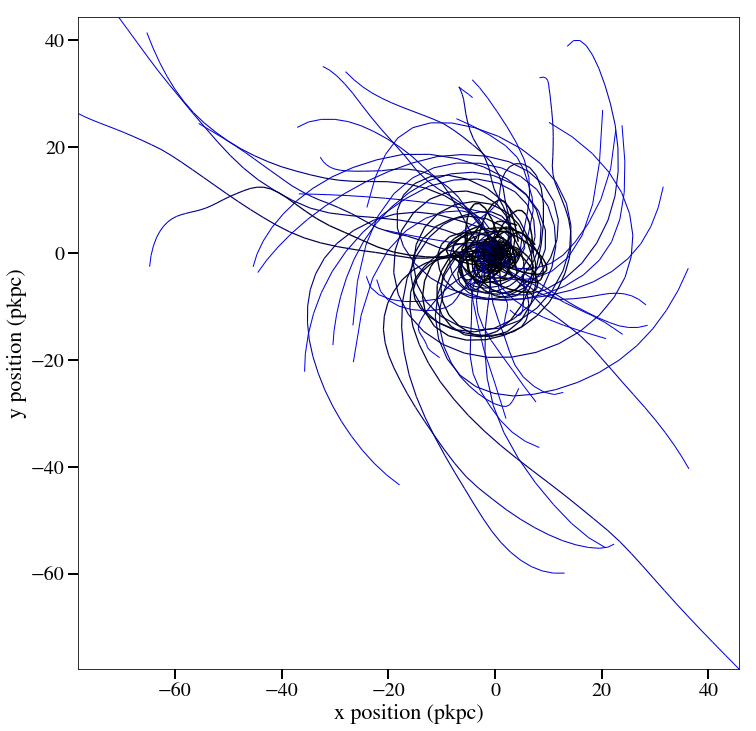

In [34]:
fig = plt.figure( figsize=(12, 12), facecolor='white' )
ax = plt.gca()

w_plotter.plot_streamlines(
#     classification = 'is_selected',
#     classification_ind = ind,
    ax = ax,
    start_ind = ind,
    end_ind = 'time_based',
    t_end = t_window,
    sample_size = 50,
    sample_selected_interval = False,
    x_data_kwargs = { 'tile_data': True, 'smooth_data' : True, 'smoothing_window_length' : 21 },
    y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 21 },
    color = 'black',
    fade_color = 'blue',
    min_fade_linewidth = 1,
)

ax.set_aspect( 'equal' )

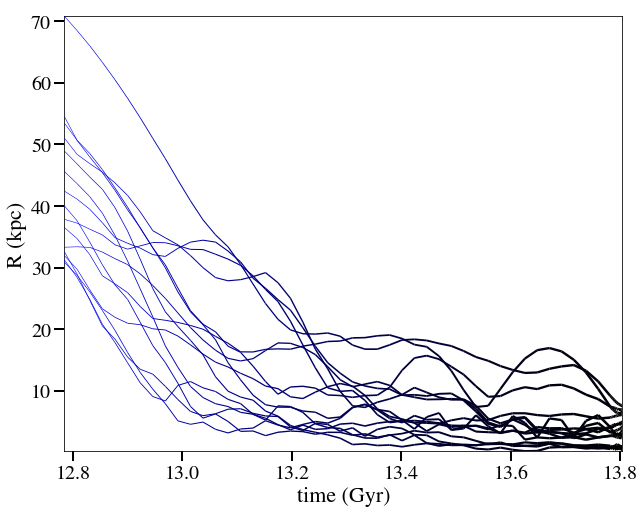

In [35]:
w_plotter.plot_streamlines(
    x_key = 'time',
    y_key = 'R',
    start_ind = ind,
    end_ind = 'time_based',
    t_end = t_window,
    sample_size = 15,
    sample_selected_interval = False,
    x_data_kwargs = {
        'tile_data': True,
        'smooth_data' : False,
        'smoothing_window_length' : 21,
    },
    y_data_kwargs = {
        'smooth_data' : False,
        'smoothing_window_length' : 21,
    },
    color = 'black',
    fade_color = 'blue',
    min_fade_linewidth = 0.5,
    linewidth = 3,
    x_label = 'time (Gyr)',
    y_label = 'R (kpc)',
)

In [36]:
w.data_masker.mask_data( 'PType', data_value=0 )

In [214]:
# Median and interval stats
logT = np.log10( w.get_selected_data( 'T', compress=False ) )#[:,ind:ind+n_snaps+1]
R = w.get_selected_data( 'R', compress=False )#[:,ind:ind+n_snaps+1]
L = w.get_selected_data( 'Lmag', compress=False )#[:,ind:ind+n_snaps+1]
M = w.get_selected_data( 'M', compress=False )#[:,ind:ind+n_snaps+1]

logT_med = np.nanmedian( logT, axis=0 )
R_med = np.nanmedian( R, axis=0 )

logT_low = np.nanpercentile( logT, 16, axis=0 )
logT_high = np.nanpercentile( logT, 84, axis=0 )

R_low = np.nanpercentile( R, 16, axis=0 )
R_high = np.nanpercentile( R, 84, axis=0 )

In [215]:
inds = []
for logT_arr in logT:
    
    ind = -1
    for i in range( logT_arr.size ):
        if logT_arr[i] > 5.:
            ind = i
            break
            
    inds.append( ind )

In [216]:
inds = np.array( inds )

In [217]:
R_at_Tcool = np.array( [ R[i, ind] for i, ind in enumerate( inds ) ] )
M_at_Tcool = np.array( [ M[i, ind] for i, ind in enumerate( inds ) ] )
L_at_Tcool = np.array( [ L[i, ind] for i, ind in enumerate( inds ) ] )

In [249]:
t_at_Tcool = np.array( [ t[ind] for ind in inds ] )

Text(0, 0.5, 'count')

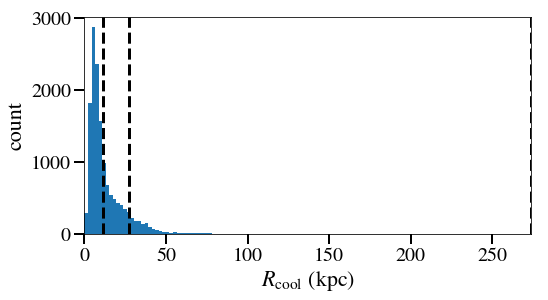

In [297]:
fig = plt.figure( figsize=(8, 4 ), facecolor='w' )
ax = plt.gca()

ax.hist(
    R_at_Tcool,
    bins = np.linspace( 0., 0.5*w.r_vir[snum], 64 ),
)

# ax.axvline(
#     np.median( R_at_Tcool ),
#     color = 'k',
# )

ax.axvline(
    w.r_gal[0],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)
ax.axvline(
    0.1 * w.r_vir[snum],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)
ax.axvline(
    w.r_vir[snum],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)

ax.set_xlim( 0, w.r_vir[snum] )

ax.set_xlabel( r'$R_{\rm{cool}}$ (kpc)', fontsize=22, )
ax.set_ylabel( 'count', fontsize=22, )

# plotting.save_fig(
    
# )

(0.19912772, 13.804038)

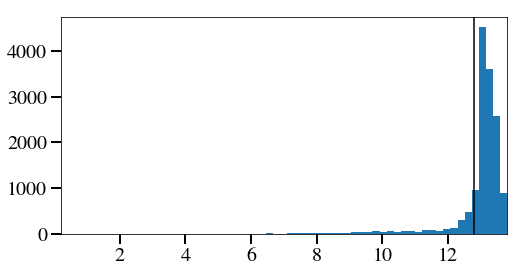

In [257]:
fig = plt.figure( figsize=(8, 4 ), facecolor='w' )
ax = plt.gca()

ax.hist(
    t_at_Tcool,
    bins = np.linspace( t.min(), t.max(), 64 ),
)

ax.axvline(
    12.8,
    color = 'k',
)

ax.set_xlim( t.min(), t.max() )
# ax.set_xscale( 'log' )

In [219]:
j_data = np.load( '../data/for_Zach.npz' )

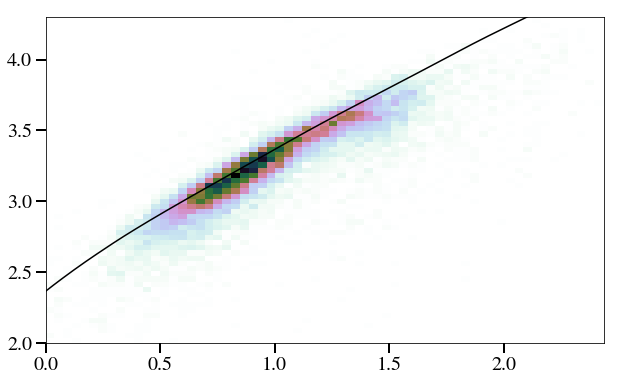

In [244]:
fig = plt.figure( figsize=(10, 6 ), facecolor='w' )
ax = plt.gca()

ax.hist2d(
    np.log10( R_at_Tcool ),
    np.log10( L_at_Tcool / M_at_Tcool ),
    bins = [ np.linspace( 0., np.log10( w.r_vir[snum] ), 64 ), np.linspace( 2, 4.3, 64 ) ],
    cmap = cm.cubehelix_r,
    normed = plt_colors.LogNorm(),
)

# ax.set_xscale( 'log' )
# ax.set_yscale( 'log' )
# ax.set_xlim( 0, w.r_vir[snum] )
# ax.set_ylim( 1e2, 3e4 )

# ax.scatter(
#     R_at_Tcool,
#     L_at_Tcool / M_at_Tcool, 
#     s = 1,
#     alpha = 0.5,
# )

ax.plot(
    np.log10( j_data['r'] ),
    np.log10( j_data['r'] * j_data['vc'] ),
    color = 'k',
)

In [130]:
logT[inds,np.arange(54)]

(14703, 54)

In [277]:
w.data_masker.clear_masks()

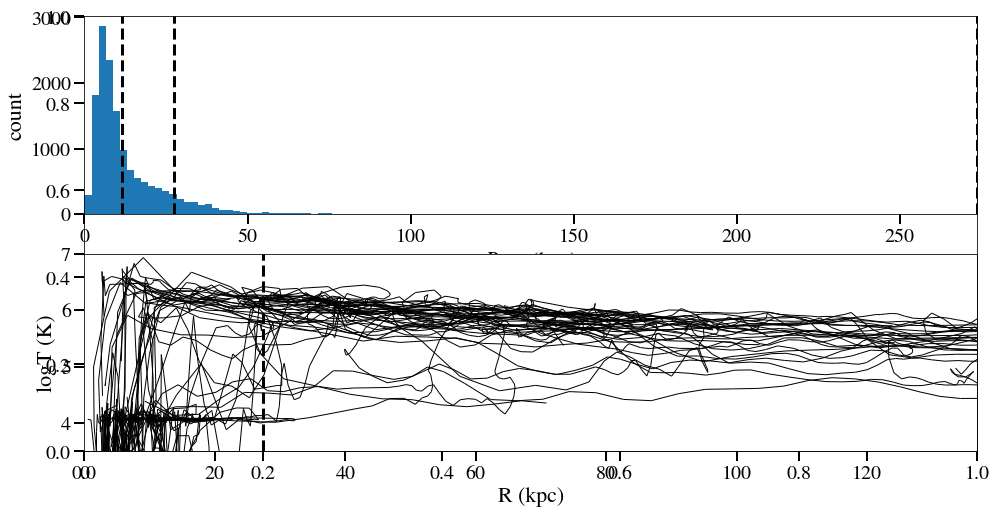

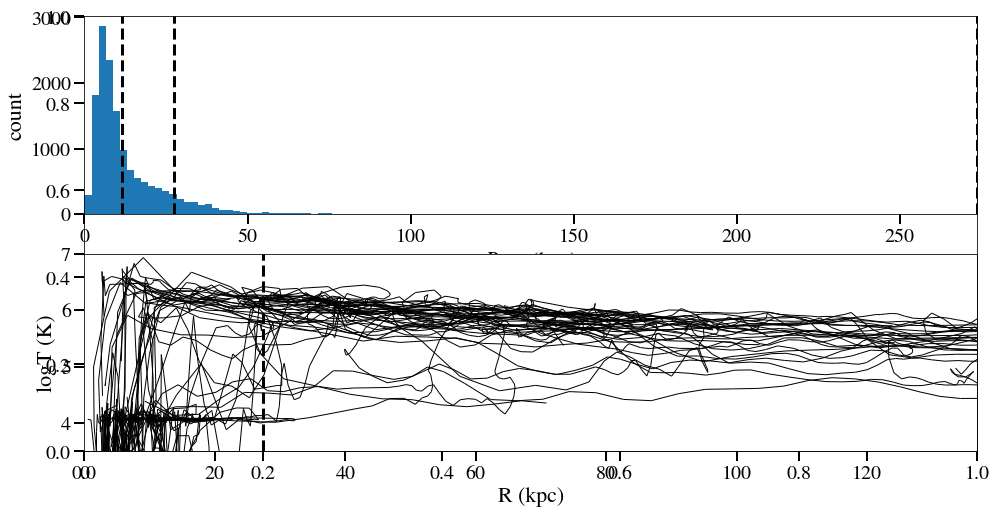

In [301]:
# np.random.seed( 6 )

fig = plt.figure( figsize=(16, 8), facecolor='w' )
ax = plt.gca()

gs = fig.add_gridspec(2, 1)

ax1 = fig.add_subplot( gs[0,0] )

ax1.hist(
    R_at_Tcool,
    bins = np.linspace( 0., 0.5*w.r_vir[snum], 64 ),
)

# ax.axvline(
#     np.median( R_at_Tcool ),
#     color = 'k',
# )

ax1.axvline(
    w.r_gal[0],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)
ax1.axvline(
    0.1 * w.r_vir[snum],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)
ax1.axvline(
    w.r_vir[snum],
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)

ax1.set_xlim( 0, w.r_vir[snum] )

ax1.set_xlabel( r'$R_{\rm{cool}}$ (kpc)', fontsize=22, )
ax1.set_ylabel( 'count', fontsize=22, )

ax2 = fig.add_subplot( gs[1,0] )

w_plotter.plot_streamlines(
    ax = ax2,
    x_key = 'R',
    y_key = 'logT',
    start_ind = ind,
    end_ind = 'time_based',
    t_end = 5.,
    sample_size = 30,
    sample_selected_interval = False,
    x_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 5 },
    y_data_kwargs = { 'smooth_data' : True, 'smoothing_window_length' : 5 },
    color = 'black',
    fade_color = 'black',
    min_fade_linewidth = 1,
#     fade_streamlines = False,
#     line_features = gas_to_star_line_features,
    linewidth = 1,
    x_label = 'R (kpc)',
    y_label = 'logT (K)',
#     y_scale = 'log',
    x_range = [ 0, w.r_vir[snum]*0.2 ],
    y_range = [ 3.5, 7 ],
#     y_floor = 10.**3.8,
)

# # In space
# w_plotter.statistic_and_interval(
#     ax = ax,
#     x_key = 'R',
#     y_key = 'logT',
#     fix_invalid = True,
#     alpha = 0.25,
#     bins = np.linspace( 0., w.r_vir[snum]*0.2, 64 ),
# )

# # Time
# ax.plot(
#     R_med,
#     logT_med,
#     linewidth = 3,
#     color = 'b',
# )
# ax.fill_between(
#     R_med,
#     logT_low,
#     logT_high,
#     color = 'b',
#     alpha = 0.25,
# )

ax2.axvline(
    w.r_vir[snum]*0.1,
    color = 'k',
    linestyle = '--',
    linewidth = 3,
)

ax2.set_xlim( 0, w.r_vir[snum]*0.5 )

fig

In [ ]:
plt.cl